# Imports Explanation
These import PyTorch modules for building and training the CNN, loading MNIST data, and visualizing results. torch.nn provides layers like Conv2D; torchvision handles datasets and transforms for image preprocessing.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Data Loading Explanation
MNIST is loaded with transforms to convert images to tensors and normalize (improves convergence). DataLoaders batch data (64 at a time) for efficient training; shuffle randomizes order to avoid bias.

100%|██████████| 9.91M/9.91M [00:01<00:00, 6.79MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 963kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.16MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.53MB/s]


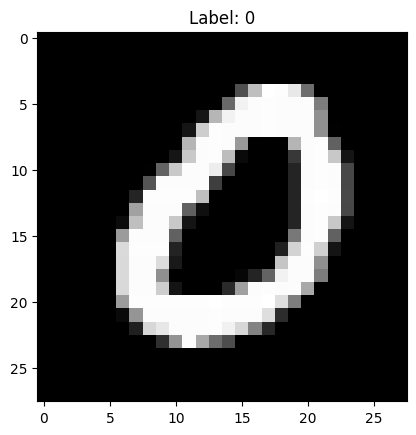

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])  # Mean and std for MNIST
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
# View sample
images, labels = next(iter(train_loader))
plt.imshow(images[0].squeeze(), cmap='gray')
plt.title(f'Label: {labels[0]}')
plt.show()

# Model Building Explanation
SimpleCNN is a PyTorch module with convolutional layers for feature detection, pooling to downsample, dropout to avoid overfitting, and fully connected layers for classification (10 classes: digits 0-9).

In [3]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(32 * 14 * 14, 128)  # After conv and pool: 28x28 -> 14x14
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout1(x)
        x = x.view(-1, 32 * 14 * 14)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Explanation
Trains the CNN over 10 epochs: For each batch, forward pass predicts, loss measures error, backward updates weights. Loss should decrease, indicating learning.

In [4]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # Training mode
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()  # Reset gradients
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()  # Backprop
        optimizer.step()  # Update weights
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}")

Epoch 1/10, Loss: 0.3504
Epoch 2/10, Loss: 0.1640
Epoch 3/10, Loss: 0.1344
Epoch 4/10, Loss: 0.1125
Epoch 5/10, Loss: 0.1017
Epoch 6/10, Loss: 0.0888
Epoch 7/10, Loss: 0.0812
Epoch 8/10, Loss: 0.0745
Epoch 9/10, Loss: 0.0668
Epoch 10/10, Loss: 0.0629


# Evaluation Explanation
Evaluates on test data: No gradients for speed; accuracy ~98%. Visualizes misclassified images to understand errors.

Test Accuracy: 98.68%


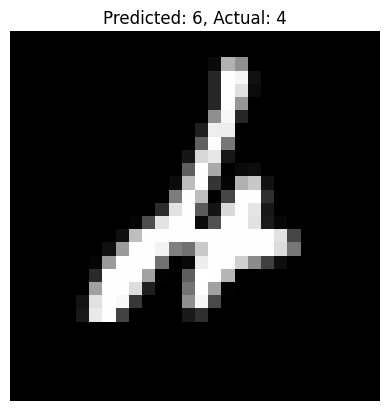

In [7]:
# Evaluate and Visualize Explanation
# Evaluates on test data: No gradients for speed; accuracy ~98%. Saves a misclassified image to show error analysis.
model.eval()  # Evaluation mode
correct = 0
total = 0
with torch.no_grad():  # No gradients
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Test Accuracy: {100 * correct / total:.2f}%")

# Visualize misclassifications (example) and save
misclassified = []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        for idx, (pred, actual) in enumerate(zip(predicted, labels)):
            if pred != actual:
                misclassified.append((images[idx], pred.item(), actual.item()))
                break  # Take first misclassification per batch
if len(misclassified) > 0:
    img, pred, actual = misclassified[0]
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f'Predicted: {pred}, Actual: {actual}')
    plt.axis('off')
    plt.savefig('misclassified.png', bbox_inches='tight')  # Save plot
    plt.show()
else:
    print("No misclassifications found!")

# Debug Explanation
Checks for overfitting; GPU accelerates if available. Save model to load later.

In [6]:
# Debug: Train accuracy (for overfitting check)
train_correct = 0
train_total = 0
model.eval()
with torch.no_grad():
    for images, labels in train_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
print(f"Train Accuracy: {100 * train_correct / train_total:.2f}%")

# Enhance: GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)  # Move model to GPU (rerun training after)

# Save model
torch.save(model.state_dict(), 'digit_model.pth')

Train Accuracy: 99.52%
